In [42]:
import pandas as pd
import numpy as np

# Combine all the csv's into one dataframe
def compile_csv(startYear, endYear):
    df_list = []
    for i in range(startYear, endYear + 1):
        off_filename = "Data/"+ str(i) + 'Offense.csv'
        def_filename = "Data/" + str(i) + 'Defense.csv'
        off_df = pd.read_csv(off_filename)
        off_df["Unit"] = ["Offense" if pos != "LS" else "Special" for pos in off_df["Pos"]]
        def_df = pd.read_csv(def_filename)
        def_df["Unit"] = ["Defense" if (pos != "K" and pos != "P") else "Special" for pos in def_df["Pos"]]
        df_list.append(off_df)
        df_list.append(def_df)
    data = pd.concat(df_list)
    return data

df = compile_csv(2000, 2017)
# Format player name
df["Player"] = [x.split("\\")[0] for x in df["Player"]]

# Parse out Drafted (tm/rnd/yr) column
df["Drafted (tm/rnd/yr)"] = df["Drafted (tm/rnd/yr)"].where(pd.notnull(df["Drafted (tm/rnd/yr)"]), None)
df["DraftTeam"] = [x.split(" / ")[0] if x != None else None for x in df["Drafted (tm/rnd/yr)"]]
df["DraftRd"] = [x.split(" / ")[1] if x != None else None for x in df["Drafted (tm/rnd/yr)"]]
df["DraftRd"] = df["DraftRd"].str.replace('[a-zA-Z]+', '')
df["DraftPick"] = [x.split(" / ")[2] if x != None else None for x in df["Drafted (tm/rnd/yr)"]]
df["DraftPick"] = df["DraftPick"].str.replace('[a-zA-Z_]+', '')
# Extract numeric part of DraftRd and convert to integers, ignoring suffixes like 'st', 'nd', 'rd'
df["DraftRdNum"] = df["DraftRd"].str.extract('(\d+)').astype(float)

# Add a new column "DraftBinary" with 1 if DraftRdNum is less than or equal to 3, else 0
df["DraftBinary"] = df["DraftRdNum"].apply(lambda x: 1 if pd.notnull(x) and x <= 5 else 0)
df = df.drop(["Drafted (tm/rnd/yr)"], axis=1)


# Convert height to inches
def convert_height(x):
    feet = x.split("-")[0]
    inches = x.split("-")[1]
    height = (int(feet) * 12) + int(inches)
    return height
df['Height'] = df['Height'].apply(convert_height)

df

df.to_csv('Data/All_Data.csv', index=False)
print(df.columns)

Index(['Rk', 'Year', 'Player', 'Pos', 'AV', 'School', 'College', 'Height',
       'Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle',
       'Unit', 'DraftTeam', 'DraftRd', 'DraftPick', 'DraftRdNum',
       'DraftBinary'],
      dtype='object')


<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/var/folders/qf/dhlpqjrs2x79ncpz_7hlk2zc0000gn/T/ipykernel_94413/2895845138.py:31: SyntaxWarning: invalid escape sequence '\d'
  df["DraftRdNum"] = df["DraftRd"].str.extract('(\d+)').astype(float)


In [2]:
# Strip out unneeded columns and handle undrafted players
df2 = df[['Year','Pos', 'Height', 'Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle','Unit', 'DraftRd']]
df2['DraftRd'] = df2['DraftRd'].fillna(8)

# impute missing values for events which players skipped with a -1
df2 = df2.fillna('-1')
df2 = df2.apply(pd.to_numeric, errors='ignore')

# calculate quartile in each event for each player within their combine year/position 
rank_40 = []
rank_vert = []
rank_bench = []
rank_broad = []
rank_3cone = []
rank_shuttle = []
for index, row in df2.iterrows():
    year = row['Year']
    position = row['Pos']
    #Calculate 40YD quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['40YD'] != -1)]["40YD"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['40YD'] != -1)]["40YD"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['40YD'] != -1)]["40YD"].quantile(.75)
    quartile = 4
    if row['40YD'] == -1:
        quartile = 5
    elif row['40YD'] <= quartile_1:
        quartile = 1
    elif row['40YD'] <= median:
        quartile = 2
    elif row['40YD'] <= quartile_3:
        quartile = 3
    rank_40.append(quartile)
    
    #Calculate vert quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Vertical'] != -1)]["Vertical"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Vertical'] != -1)]["Vertical"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Vertical'] != -1)]["Vertical"].quantile(.75)
    quartile = 4
    if row['Vertical'] == -1:
        quartile = 5
    elif row['Vertical'] >= quartile_3:
        quartile = 1
    elif row['Vertical'] >= median:
        quartile = 2
    elif row['Vertical'] >= quartile_1:
        quartile = 3
    rank_vert.append(quartile)
    
    #Calculate BenchReps quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['BenchReps'] != -1)]["BenchReps"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['BenchReps'] != -1)]["BenchReps"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['BenchReps'] != -1)]["BenchReps"].quantile(.75)
    quartile = 4
    if row['BenchReps'] == -1:
        quartile = 5
    elif row['BenchReps'] >= quartile_3:
        quartile = 1
    elif row['BenchReps'] >= median:
        quartile = 2
    elif row['BenchReps'] >= quartile_1:
        quartile = 3
    rank_bench.append(quartile)
    
    #Calculate Broad Jump quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Broad Jump'] != -1)]["Broad Jump"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Broad Jump'] != -1)]["Broad Jump"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Broad Jump'] != -1)]["Broad Jump"].quantile(.75)
    quartile = 4
    if row['Broad Jump'] == -1:
        quartile = 5
    elif row['Broad Jump'] >= quartile_3:
        quartile = 1
    elif row['Broad Jump'] >= median:
        quartile = 2
    elif row['Broad Jump'] >= quartile_1:
        quartile = 3
    rank_broad.append(quartile)
    
    #Calculate 3Cone quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['3Cone'] != -1)]["3Cone"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['3Cone'] != -1)]["3Cone"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['3Cone'] != -1)]["3Cone"].quantile(.75)
    quartile = 4
    if row['3Cone'] == -1:
        quartile = 5
    elif row['3Cone'] <= quartile_1:
        quartile = 1
    elif row['3Cone'] <= median:
        quartile = 2
    elif row['3Cone'] <= quartile_3:
        quartile = 3
    rank_3cone.append(quartile)
    
    #Calculate Shuttle quartile
    quartile_1 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Shuttle'] != -1)]["Shuttle"].quantile(.25)
    median = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Shuttle'] != -1)]["Shuttle"].quantile(.5)
    quartile_3 = df2[(df2['Year'] == year) & (df2['Pos'] == position) & (df2['Shuttle'] != -1)]["Shuttle"].quantile(.75)
    quartile = 4
    if row['Shuttle'] == -1:
        quartile = 5
    elif row['Shuttle'] <= quartile_1:
        quartile = 1
    elif row['Shuttle'] <= median:
        quartile = 2
    elif row['Shuttle'] <= quartile_3:
        quartile = 3
    rank_shuttle.append(quartile)
df2['40_quartile_yr_pos'] = rank_40 
df2['vert_quartile_yr_pos'] = rank_vert
df2['bench_quartile_yr_pos'] = rank_bench
df2['broad_quartile_yr_pos'] = rank_broad
df2['3cone_quartile_yr_pos'] = rank_3cone
df2['shuttle_quartile_yr_pos'] = rank_shuttle
df2

/var/folders/qf/dhlpqjrs2x79ncpz_7hlk2zc0000gn/T/ipykernel_94413/2889184105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DraftRd'] = df2['DraftRd'].fillna(8)
/var/folders/qf/dhlpqjrs2x79ncpz_7hlk2zc0000gn/T/ipykernel_94413/2889184105.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df2 = df2.apply(pd.to_numeric, errors='ignore')


,Year,Pos,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Unit,DraftRd,40_quartile_yr_pos,vert_quartile_yr_pos,bench_quartile_yr_pos,broad_quartile_yr_pos,3cone_quartile_yr_pos,shuttle_quartile_yr_pos
0,2000,WR,75,191,4.53,33.0,-1.0,130.0,7.09,4.18,Offense,8,2,3,5,1,3,3
1,2000,QB,75,229,4.91,34.0,-1.0,108.0,7.71,4.59,Offense,6th,2,1,5,2,4,4
2,2000,WR,71,180,4.59,36.0,-1.0,123.0,7.22,4.16,Offense,6th,3,2,5,1,4,2
3,2000,OT,76,332,5.26,29.0,28.0,97.0,7.78,4.72,Offense,2nd,2,1,1,3,2,1
4,2000,RB,71,193,4.50,-1.0,-1.0,-1.0,-1.00,-1.00,Offense,5th,1,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2017,DT,73,319,5.04,28.5,25.0,108.0,7.73,4.65,Defense,8,2,1,2,2,4,3
145,2017,DE,79,289,4.83,30.0,23.0,128.0,7.46,4.62,Defense,8,3,4,3,1,4,4
146,2017,DE,75,264,4.79,32.5,14.0,114.0,7.25,4.43,Defense,8,2,2,4,3,3,3
147,2017,DE,76,248,4.61,35.0,30.0,123.0,6.94,4.40,Defense,8,1,1,1,2,1,2


              precision    recall  f1-score   support

           0       0.66      0.73      0.69       580
           1       0.68      0.60      0.64       548

    accuracy                           0.67      1128
   macro avg       0.67      0.66      0.66      1128
weighted avg       0.67      0.67      0.67      1128

ROC AUC Score: 0.7292600050339795


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


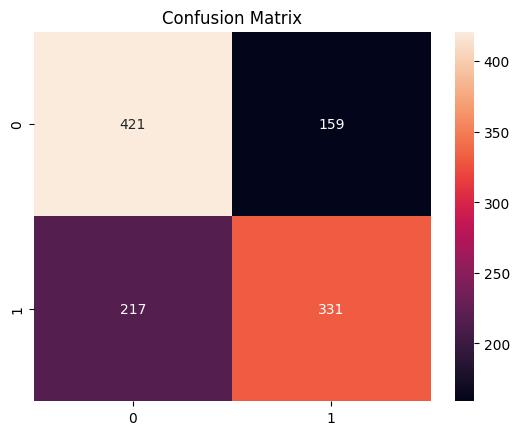

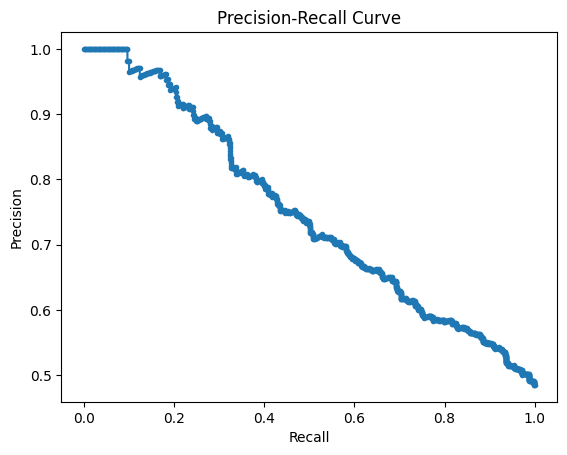

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and target
X = df[["Height","Wt","Vertical","40YD","Broad Jump","3Cone","AV"]]
y = df["DraftBinary"]

# Handle missing values
X = X.fillna(X.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()